### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statistics import mean
import tensorflow as tf

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_Landsat9.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = arrFeatures.astype(float)

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7), value=1), Output()), _dom_cl…

### Generating chips

In [4]:
# normalize the image and generate chips
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i, :, :].min()
    bandMax = arrFeatures[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures_fuzzy[i, j, k] = (arrFeatures[i, j, k]-bandMin)/bandRange

# create chips using pyrsgis
features_chips = imageChipsFromArray(arrFeatures_fuzzy, x_size=7, y_size=7)

### Loading the training dataset (manual)

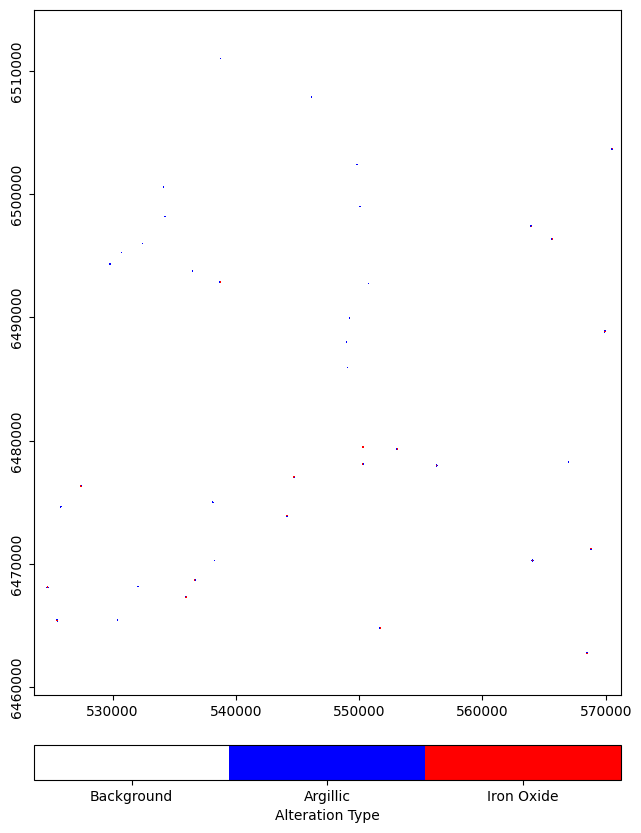

In [5]:
positiveLabel_file = './BrokenHill_Landsat8_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0

### Splitting features and labels into training and test datasets

In [7]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

Epoch 1/100
33/33 [==============================] - 1s 7ms/step - loss: 1.1107 - accuracy: 0.3352 - val_loss: 1.0754 - val_accuracy: 0.3356
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0446 - accuracy: 0.4800 - val_loss: 0.9305 - val_accuracy: 0.6022
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8476 - accuracy: 0.6390 - val_loss: 0.6373 - val_accuracy: 0.8178
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.7248 - val_loss: 0.5490 - val_accuracy: 0.8067
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.7552 - val_loss: 0.4550 - val_accuracy: 0.8689
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5436 - accuracy: 0.7981 - val_loss: 0.3959 - val_accuracy: 0.8778
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.4628 - accuracy: 0.8429 - val_loss: 0.3600 - val_accuracy: 0.8800
Epoch 8/100
3

Epoch 59/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1846 - accuracy: 0.9305 - val_loss: 0.1433 - val_accuracy: 0.9467
Epoch 60/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1685 - accuracy: 0.9362 - val_loss: 0.1368 - val_accuracy: 0.9556
Epoch 61/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1447 - accuracy: 0.9543 - val_loss: 0.1392 - val_accuracy: 0.9511
Epoch 62/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1339 - accuracy: 0.9571 - val_loss: 0.1137 - val_accuracy: 0.9578
Epoch 63/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1380 - accuracy: 0.9533 - val_loss: 0.1535 - val_accuracy: 0.9511
Epoch 64/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1266 - accuracy: 0.9600 - val_loss: 0.1436 - val_accuracy: 0.9422
Epoch 65/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1697 - accuracy: 0.9400 - val_loss: 0.1285 - val_accuracy: 0.9533
Epoch 

Epoch 67/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1202 - accuracy: 0.9629 - val_loss: 0.1437 - val_accuracy: 0.9489
Epoch 68/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1132 - accuracy: 0.9619 - val_loss: 0.1662 - val_accuracy: 0.9400
Epoch 69/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1649 - accuracy: 0.9486 - val_loss: 0.1772 - val_accuracy: 0.9356
Epoch 70/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1218 - accuracy: 0.9581 - val_loss: 0.1567 - val_accuracy: 0.9511
Epoch 71/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1120 - accuracy: 0.9619 - val_loss: 0.1405 - val_accuracy: 0.9556
Epoch 72/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1192 - accuracy: 0.9638 - val_loss: 0.1526 - val_accuracy: 0.9489
Epoch 73/100
33/33 [==============================] - 0s 5ms/step - loss: 0.1193 - accuracy: 0.9619 - val_loss: 0.1756 - val_accuracy: 0.9378
Epoch 

Epoch 75/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1154 - accuracy: 0.9600 - val_loss: 0.0932 - val_accuracy: 0.9733
Epoch 76/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1406 - accuracy: 0.9562 - val_loss: 0.1533 - val_accuracy: 0.9267
Epoch 77/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9543 - val_loss: 0.1125 - val_accuracy: 0.9711
Epoch 78/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1242 - accuracy: 0.9590 - val_loss: 0.0903 - val_accuracy: 0.9756
Epoch 79/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1579 - accuracy: 0.9467 - val_loss: 0.0930 - val_accuracy: 0.9733
Epoch 80/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9581 - val_loss: 0.0899 - val_accuracy: 0.9778
Epoch 81/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9600 - val_loss: 0.0971 - val_accuracy: 0.9778
Epoch 

33/33 [==============================] - 0s 3ms/step - loss: 0.2446 - accuracy: 0.9114 - val_loss: 0.1947 - val_accuracy: 0.9244
Epoch 26/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2489 - accuracy: 0.9095 - val_loss: 0.1915 - val_accuracy: 0.9333
Epoch 27/100
33/33 [==============================] - 0s 4ms/step - loss: 0.2311 - accuracy: 0.9162 - val_loss: 0.1807 - val_accuracy: 0.9356
Epoch 28/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2348 - accuracy: 0.9200 - val_loss: 0.1757 - val_accuracy: 0.9378
Epoch 29/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2496 - accuracy: 0.9114 - val_loss: 0.2124 - val_accuracy: 0.9133
Epoch 30/100
33/33 [==============================] - 0s 4ms/step - loss: 0.2291 - accuracy: 0.9267 - val_loss: 0.2447 - val_accuracy: 0.8911
Epoch 31/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9143 - val_loss: 0.2224 - val_accuracy: 0.9156
Epoch 32/100
33/33 

Epoch 83/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.9438 - val_loss: 0.1149 - val_accuracy: 0.9689
Epoch 84/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1451 - accuracy: 0.9486 - val_loss: 0.1473 - val_accuracy: 0.9467
Epoch 85/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.9371 - val_loss: 0.1521 - val_accuracy: 0.9444
Epoch 86/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1702 - accuracy: 0.9381 - val_loss: 0.1174 - val_accuracy: 0.9667
Epoch 87/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1288 - accuracy: 0.9514 - val_loss: 0.1347 - val_accuracy: 0.9600
Epoch 88/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9571 - val_loss: 0.1166 - val_accuracy: 0.9644
Epoch 89/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1224 - accuracy: 0.9514 - val_loss: 0.1171 - val_accuracy: 0.9600
Epoch 

Epoch 91/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1115 - accuracy: 0.9600 - val_loss: 0.1083 - val_accuracy: 0.9711
Epoch 92/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1096 - accuracy: 0.9619 - val_loss: 0.1207 - val_accuracy: 0.9711
Epoch 93/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0957 - accuracy: 0.9657 - val_loss: 0.1123 - val_accuracy: 0.9600
Epoch 94/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1249 - accuracy: 0.9552 - val_loss: 0.1453 - val_accuracy: 0.9667
Epoch 95/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1135 - accuracy: 0.9581 - val_loss: 0.1000 - val_accuracy: 0.9644
Epoch 96/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0951 - accuracy: 0.9686 - val_loss: 0.0994 - val_accuracy: 0.9711
Epoch 97/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0960 - accuracy: 0.9648 - val_loss: 0.0968 - val_accuracy: 0.9733
Epoch 

Epoch 99/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1338 - accuracy: 0.9505 - val_loss: 0.1263 - val_accuracy: 0.9644
Epoch 100/100
15/15 [==============================] - 0s 963us/step
Epoch 1/100
33/33 [==============================] - 1s 6ms/step - loss: 1.0747 - accuracy: 0.4133 - val_loss: 0.9659 - val_accuracy: 0.5200
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.8890 - accuracy: 0.6095 - val_loss: 0.7096 - val_accuracy: 0.7600
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.7512 - accuracy: 0.6771 - val_loss: 0.6668 - val_accuracy: 0.6222
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.7333 - val_loss: 0.5270 - val_accuracy: 0.8111
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5739 - accuracy: 0.7848 - val_loss: 0.4643 - val_accuracy: 0.8311
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5193 - ac

15/15 [==============================] - 0s 1ms/step
Epoch 1/100
33/33 [==============================] - 1s 7ms/step - loss: 1.0837 - accuracy: 0.4019 - val_loss: 1.0225 - val_accuracy: 0.5067
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9683 - accuracy: 0.5495 - val_loss: 0.8502 - val_accuracy: 0.6333
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8053 - accuracy: 0.6238 - val_loss: 0.7058 - val_accuracy: 0.6911
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.7310 - accuracy: 0.6752 - val_loss: 0.6308 - val_accuracy: 0.7667
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6933 - val_loss: 0.6259 - val_accuracy: 0.7756
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.7267 - val_loss: 0.6026 - val_accuracy: 0.7622
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.7419 - 

Epoch 57/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.9419 - val_loss: 0.1209 - val_accuracy: 0.9667
Epoch 58/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1447 - accuracy: 0.9543 - val_loss: 0.1230 - val_accuracy: 0.9622
Epoch 59/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1378 - accuracy: 0.9543 - val_loss: 0.1177 - val_accuracy: 0.9578
Epoch 60/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1293 - accuracy: 0.9610 - val_loss: 0.1192 - val_accuracy: 0.9578
Epoch 61/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1548 - accuracy: 0.9524 - val_loss: 0.1140 - val_accuracy: 0.9733
Epoch 62/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1657 - accuracy: 0.9343 - val_loss: 0.1305 - val_accuracy: 0.9489
Epoch 63/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1465 - accuracy: 0.9438 - val_loss: 0.1148 - val_accuracy: 0.9689
Epoch 

Epoch 65/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1101 - accuracy: 0.9629 - val_loss: 0.1227 - val_accuracy: 0.9600
Epoch 66/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1078 - accuracy: 0.9657 - val_loss: 0.1368 - val_accuracy: 0.9533
Epoch 67/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1347 - accuracy: 0.9562 - val_loss: 0.1496 - val_accuracy: 0.9444
Epoch 68/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 0.9590 - val_loss: 0.1230 - val_accuracy: 0.9533
Epoch 69/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1023 - accuracy: 0.9686 - val_loss: 0.1293 - val_accuracy: 0.9511
Epoch 70/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9648 - val_loss: 0.1115 - val_accuracy: 0.9644
Epoch 71/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1108 - accuracy: 0.9629 - val_loss: 0.1327 - val_accuracy: 0.9556
Epoch 

Epoch 73/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1294 - accuracy: 0.9533 - val_loss: 0.1279 - val_accuracy: 0.9600
Epoch 74/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1203 - accuracy: 0.9610 - val_loss: 0.1241 - val_accuracy: 0.9578
Epoch 75/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9657 - val_loss: 0.1058 - val_accuracy: 0.9622
Epoch 76/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1215 - accuracy: 0.9600 - val_loss: 0.1369 - val_accuracy: 0.9511
Epoch 77/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1053 - accuracy: 0.9705 - val_loss: 0.1161 - val_accuracy: 0.9556
Epoch 78/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1285 - accuracy: 0.9552 - val_loss: 0.1765 - val_accuracy: 0.9422
Epoch 79/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1374 - accuracy: 0.9514 - val_loss: 0.2769 - val_accuracy: 0.8933
Epoch 

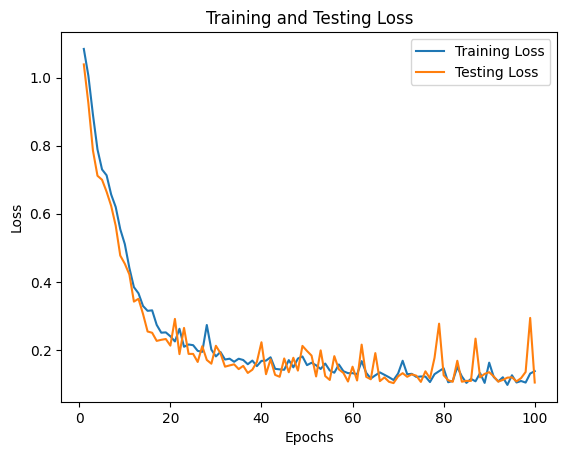

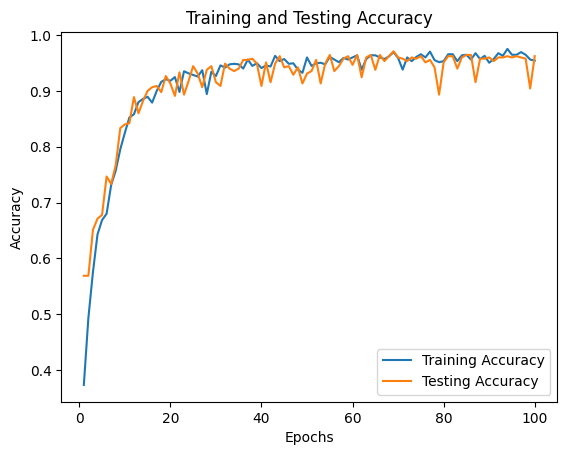

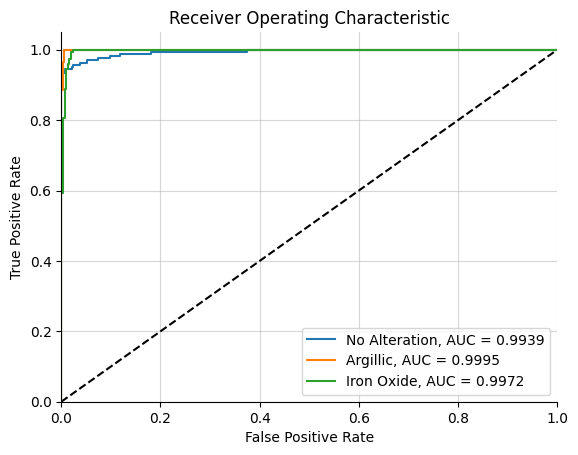

ROC AUC score: 0.9968943814665492


In [8]:
def roc_auc(model, test_x, test_y, n_classes):
    roc_auc = []
    test_z = model.predict(test_x)
    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        roc_auc.append(roc_auc_score(test_y_dummies[:, i], test_z[:, i]))
    
    return roc_auc

# plot any graph relating to any model
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and Testing '+metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['Training '+metric.capitalize(), 'Testing '+metric.capitalize()])
    plt.show()
    
def roc_plot(test_y, test_z, n_classes, labels_name, average='macro'):
    fpr = {}
    tpr = {}
    roc_auc = {}

    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], test_z[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{}, AUC = {}'.format(labels_name[i], '{0:.4f}'.format(roc_auc[i])))
    
    ax.legend(loc='best')
    ax.grid(alpha=0.5)
    sns.despine()
    plt.show()
    print('ROC AUC score:', roc_auc_score(test_y_dummies, test_z, average=average))

best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 10
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Iron Oxide', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))

    for j in range(cv):
        train_x, train_y, test_x, test_y = train_test_split(features, labels)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Iron Oxide']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

91947/91947 [==============================] - 74s 807us/step


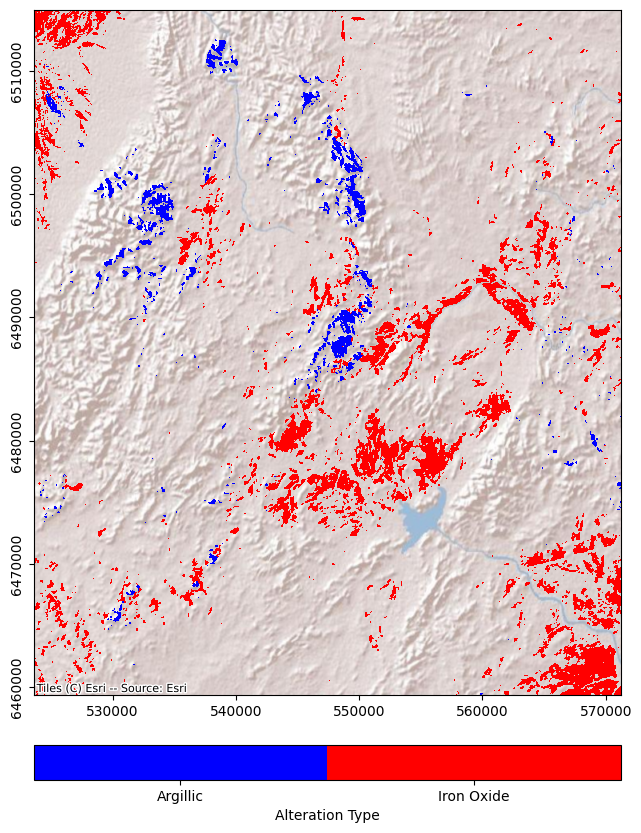

In [9]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat9.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

for i in range(arrPred.shape[0]):
    bandMin = arrPred[i, :, :].min()
    bandMax = arrPred[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[1]):
        for k in range(arrPred.shape[2]):
            arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# generate image chips from the array
pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

# predict and export the probability raster
pred = best_model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

outFile = './Outputs/BrokenHill_Landsat9_Manual_CNN_AlterationMap_ks_7.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

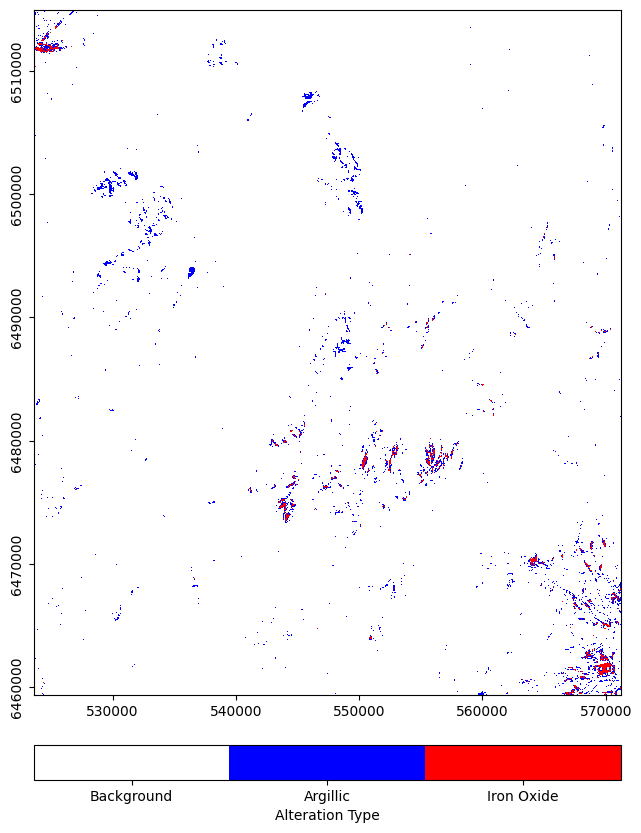

In [10]:
positiveLabel_file = './BrokenHill_Landsat9_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [11]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0

### Splitting features and labels into training and test datasets

In [12]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

Epoch 1/50
1781/1781 [==============================] - 18s 10ms/step - loss: 0.4638 - accuracy: 0.8157 - val_loss: 0.2337 - val_accuracy: 0.9142
Epoch 2/50
1781/1781 [==============================] - 17s 10ms/step - loss: 0.2907 - accuracy: 0.8949 - val_loss: 0.2174 - val_accuracy: 0.9194
Epoch 3/50
1781/1781 [==============================] - 17s 9ms/step - loss: 0.2466 - accuracy: 0.9134 - val_loss: 0.1864 - val_accuracy: 0.9322
Epoch 4/50
1781/1781 [==============================] - 19s 11ms/step - loss: 0.2196 - accuracy: 0.9247 - val_loss: 0.1555 - val_accuracy: 0.9439
Epoch 5/50
1781/1781 [==============================] - 18s 10ms/step - loss: 0.2041 - accuracy: 0.9312 - val_loss: 0.1411 - val_accuracy: 0.9484
Epoch 6/50
1781/1781 [==============================] - 17s 9ms/step - loss: 0.1864 - accuracy: 0.9357 - val_loss: 0.1275 - val_accuracy: 0.9575
Epoch 7/50
1781/1781 [==============================] - 17s 9ms/step - loss: 0.1743 - accuracy: 0.9419 - val_loss: 0.1132 - va

764/764 [==============================] - 2s 3ms/step
Epoch 1/50
1781/1781 [==============================] - 19s 10ms/step - loss: 0.4487 - accuracy: 0.8228 - val_loss: 0.2267 - val_accuracy: 0.9175
Epoch 2/50
1781/1781 [==============================] - 18s 10ms/step - loss: 0.2695 - accuracy: 0.9060 - val_loss: 0.1904 - val_accuracy: 0.9327
Epoch 3/50
1781/1781 [==============================] - 16s 9ms/step - loss: 0.2312 - accuracy: 0.9200 - val_loss: 0.2408 - val_accuracy: 0.9153
Epoch 4/50
1781/1781 [==============================] - 16s 9ms/step - loss: 0.2033 - accuracy: 0.9308 - val_loss: 0.1730 - val_accuracy: 0.9411
Epoch 5/50
1781/1781 [==============================] - 17s 10ms/step - loss: 0.1894 - accuracy: 0.9352 - val_loss: 0.1330 - val_accuracy: 0.9549
Epoch 6/50
1781/1781 [==============================] - 18s 10ms/step - loss: 0.1734 - accuracy: 0.9421 - val_loss: 0.1004 - val_accuracy: 0.9649
Epoch 7/50
1781/1781 [==============================] - 18s 10ms/step -

764/764 [==============================] - 2s 3ms/step
Epoch 1/50
1781/1781 [==============================] - 18s 10ms/step - loss: 0.5086 - accuracy: 0.7890 - val_loss: 0.2732 - val_accuracy: 0.8927
Epoch 2/50
1781/1781 [==============================] - 17s 10ms/step - loss: 0.2960 - accuracy: 0.8968 - val_loss: 0.1951 - val_accuracy: 0.9284
Epoch 3/50
1781/1781 [==============================] - 17s 10ms/step - loss: 0.2530 - accuracy: 0.9123 - val_loss: 0.2502 - val_accuracy: 0.9093
Epoch 4/50
1781/1781 [==============================] - 17s 10ms/step - loss: 0.2180 - accuracy: 0.9262 - val_loss: 0.1422 - val_accuracy: 0.9505
Epoch 5/50
1781/1781 [==============================] - 19s 11ms/step - loss: 0.1941 - accuracy: 0.9353 - val_loss: 0.1664 - val_accuracy: 0.9391
Epoch 6/50
1781/1781 [==============================] - 16s 9ms/step - loss: 0.1774 - accuracy: 0.9408 - val_loss: 0.1912 - val_accuracy: 0.9319
Epoch 7/50
1781/1781 [==============================] - 16s 9ms/step -

764/764 [==============================] - 2s 3ms/step

Best Average Accuracy:
0.9851414997747472
764/764 [==============================] - 2s 2ms/step

Confusion Matrix:
[[8043  113  141]
 [ 104 7876    9]
 [   7    0 8124]]

Accuracy: 0.9846828029651472

Precision: 0.9847045072137744

Recall: 0.9847937246384163

F1 Score: 0.9846993991078058


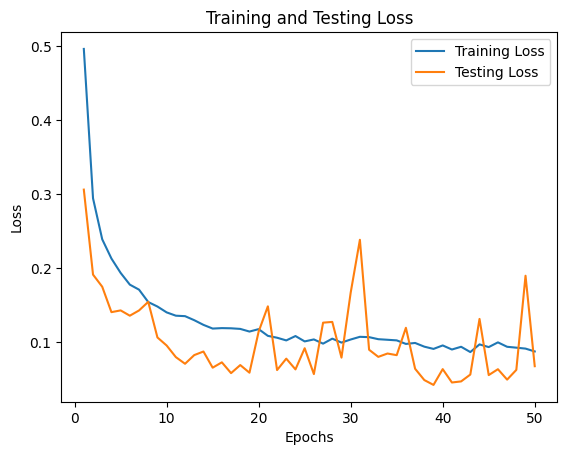

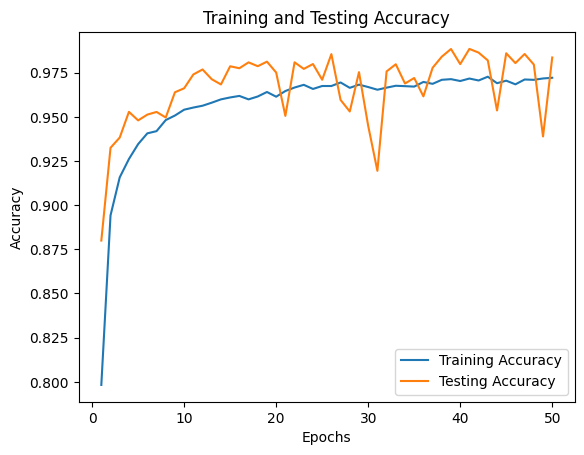

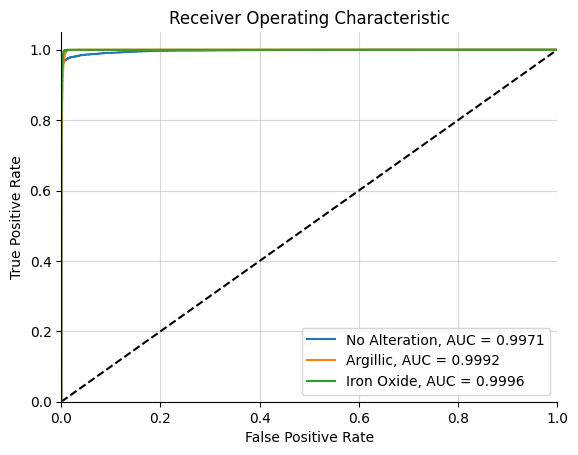

ROC AUC score: 0.9986299312374752


In [13]:
best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 5
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Iron Oxide', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=50, validation_data=(test_x, test_y))

    for j in range(cv):
        train_x, train_y, test_x, test_y = train_test_split(features, labels)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Iron Oxide']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

91947/91947 [==============================] - 200s 2ms/step


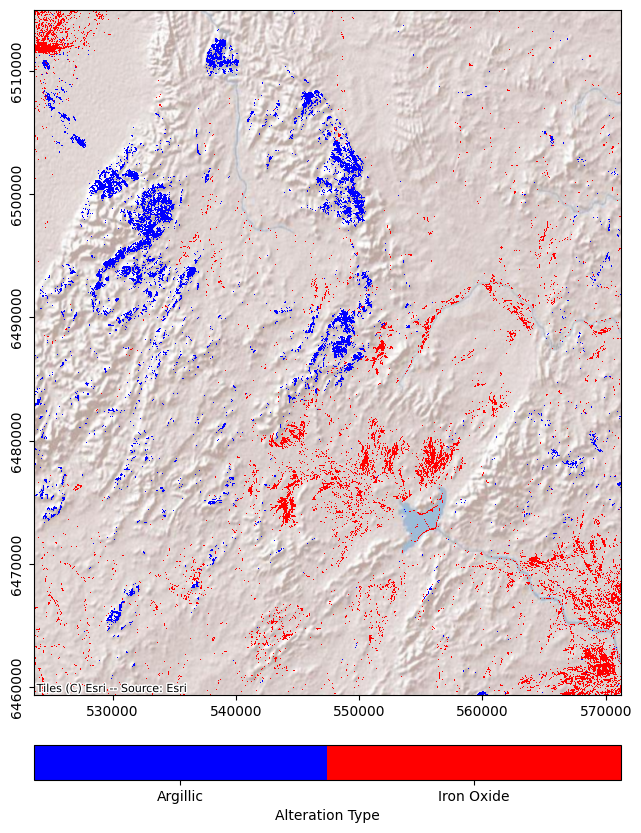

In [14]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_Landsat9.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

for i in range(arrPred.shape[0]):
    bandMin = arrPred[i, :, :].min()
    bandMax = arrPred[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[1]):
        for k in range(arrPred.shape[2]):
            arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# generate image chips from the array
pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

# predict and export the probability raster
pred = best_model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

outFile = './Outputs/BrokenHill_Landsat9_PCA_CNN_AlterationMap_ks_7.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')